<a href="https://colab.research.google.com/github/debashisdotchatterjee/AI-MLStatistical-Spatio-Temporal-Prospectivity-Modelling-for-Critical-Minerals-Hackathon/blob/main/Geochronology_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ace_tools

In [ ]:
# utils.py  ─────────────────────────────────────────────────────────────
def safe_display_df(name, df):
    """
    Replace ace_tools.display_dataframe_to_user.
    In Jupyter/Colab it shows an HTML table; in a plain script it prints Markdown.
    """
    try:
        from IPython.display import display, HTML
        display(HTML(f"<h4>{name}</h4>"))
        display(df)
    except Exception:
        print(f"\n--- {name} ---")
        print(df.to_markdown())


In [ ]:
!pip install geopandas matplotlib shapely pyproj fiona rtree contextily \
             pymc xarray tqdm torch torch-geometric --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#  Full EDA script

>> Extracting dataset …
>> Outlier filter removed 3 / 63 points


,Count,Min,Q1,Median,Mean,Q3,Max
method,,,,,,,
K–Ar,8,1124.0,1449.8,1673.5,1632.9,1880.2,1938.0
Rb–Sr,25,1091.0,2159.0,2345.0,2245.0,2595.0,2970.0
Sm–Nd,4,2648.0,2703.5,2734.5,2801.8,2832.8,3090.0
U–Pb,23,1270.0,2559.5,2651.0,2650.8,2975.0,3360.0


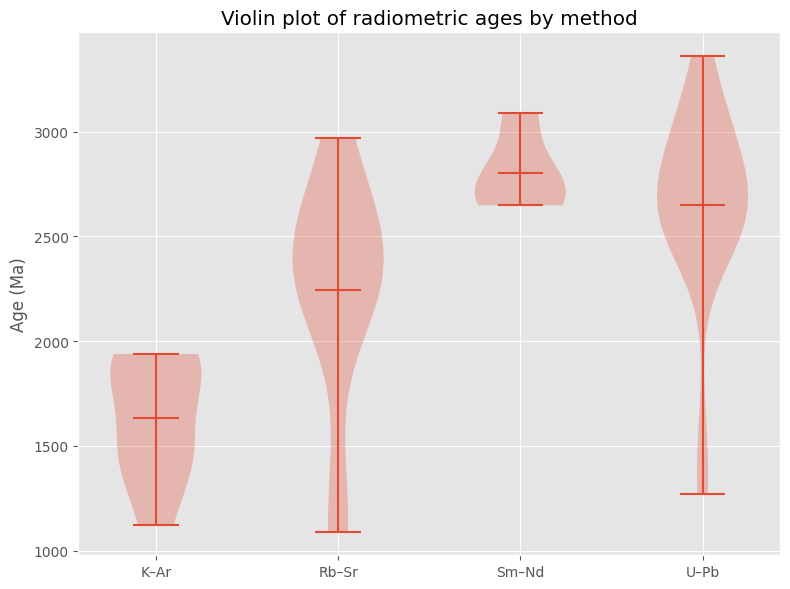

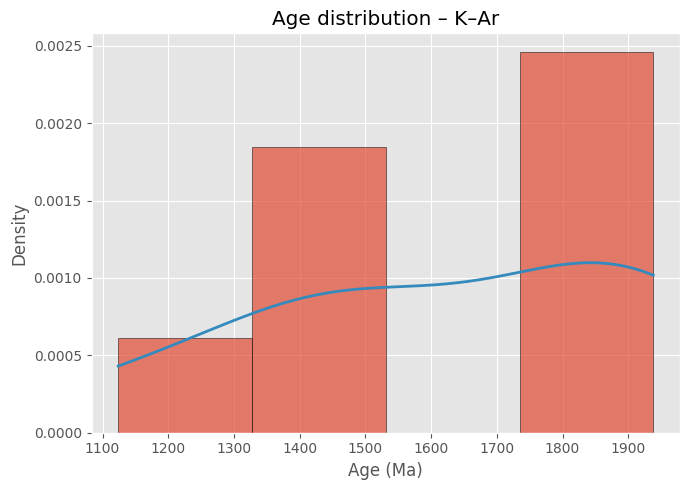

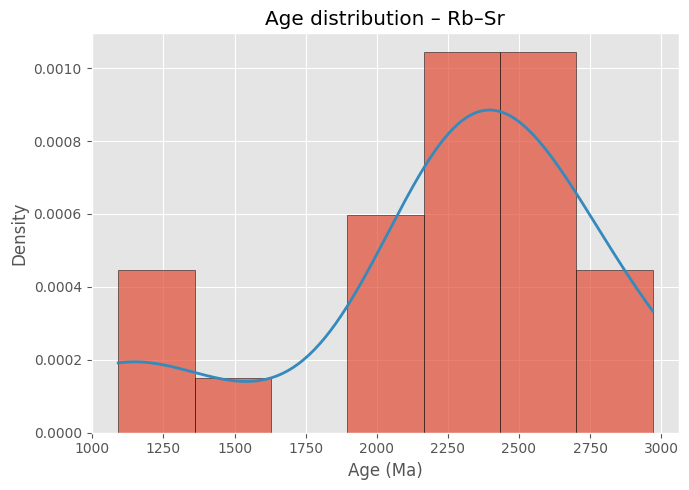

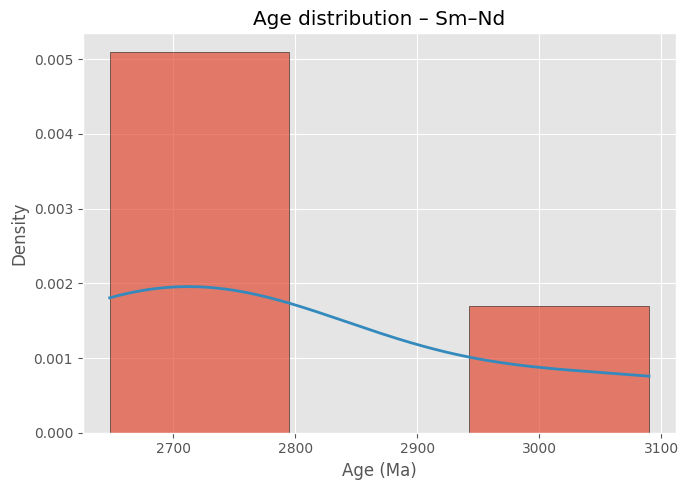

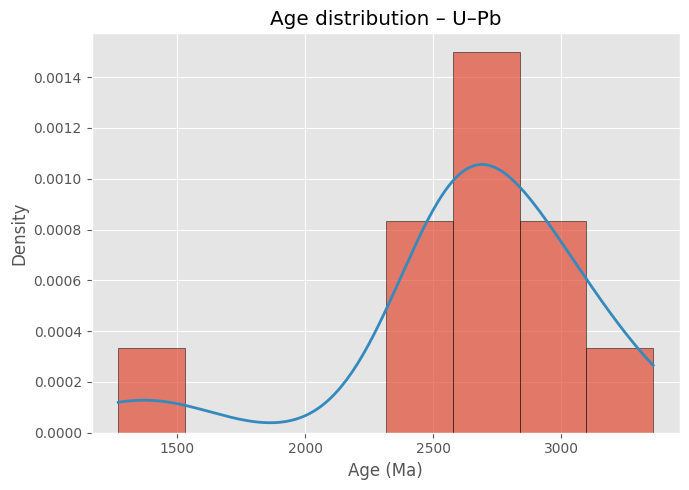

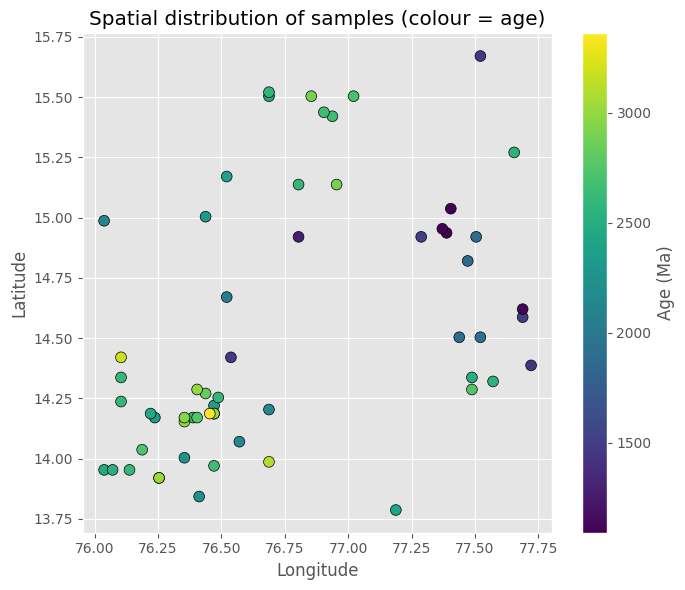


>> Track I demo (PyMC latent GP + logistic link)


Output()

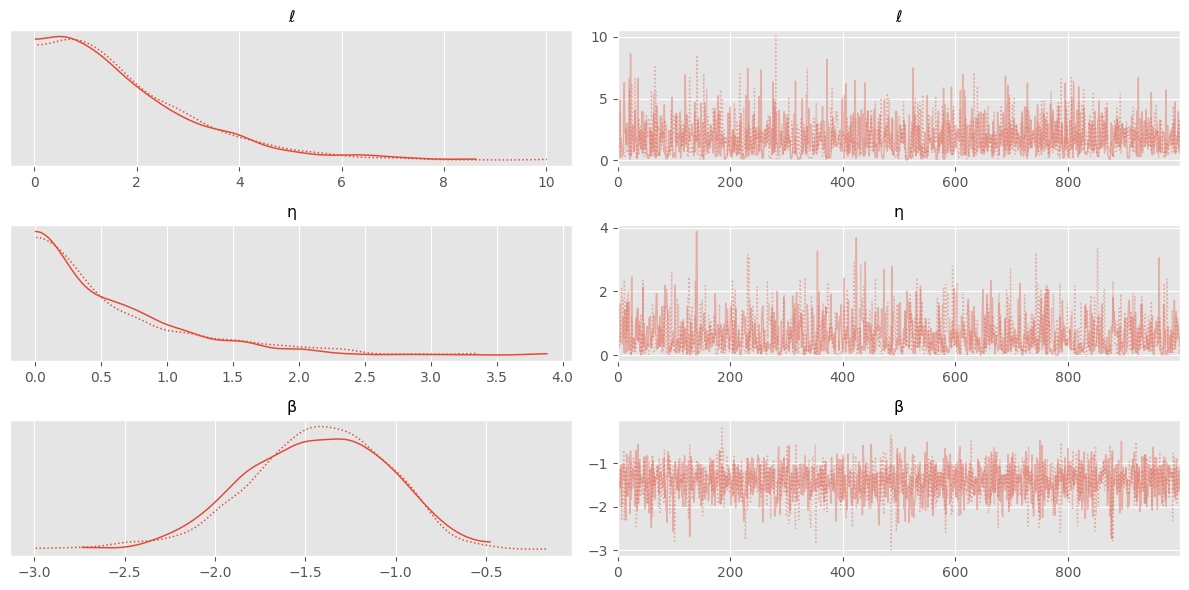

>> Posterior mean β: -1.4336955320188713

All outputs saved under: /content/outputs


In [ ]:
"""
Hackathon 2025 – Complete Workflow
Author : Debashis Chatterjee  (June 2025)
Run    : python hackathon_workflow.py           # in a terminal
      –or–
         %run hackathon_workflow.py             # in Jupyter / Colab
"""

# ───────────────────────────────────────────────────────────────────────
#  Imports
# ───────────────────────────────────────────────────────────────────────
import os, zipfile, glob, warnings, sys, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.covariance import MinCovDet
import pymc as pm
import arviz as az

# Deep-learning (place-holders)
import torch
from torch import nn
from torch_geometric.nn import GCNConv

# ───────────────────────────────────────────────────────────────────────
#  Helper → pretty DataFrame print that works everywhere
# ───────────────────────────────────────────────────────────────────────
def show_df(name: str, df: pd.DataFrame):
    """
    If running inside IPython display the HTML table;
    otherwise print Markdown to console.
    """
    try:
        from IPython.display import display, HTML
        display(HTML(f"<h4>{name}</h4>"))
        display(df)
    except Exception:
        print(f"\n--- {name} ---")
        print(df.to_markdown())

# ───────────────────────────────────────────────────────────────────────
#  Paths
# ───────────────────────────────────────────────────────────────────────
ZIP_FILE   = "geochronology_map_of_karnataka_and_andhra_pradesh_v1.zip"
BASE_DIR   = Path(".").resolve()
EXTRACT_TO = BASE_DIR / "geo_extract"
OUT_DIR    = BASE_DIR / "outputs"
EXTRACT_TO.mkdir(exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────────────────────────────
#  1.  Unzip data if not done yet
# ───────────────────────────────────────────────────────────────────────
if not any(EXTRACT_TO.iterdir()):
    print(">> Extracting dataset …")
    with zipfile.ZipFile(ZIP_FILE, "r") as z:
        z.extractall(EXTRACT_TO)
else:
    print(">> Archive already extracted")

# ───────────────────────────────────────────────────────────────────────
#  2.  Load all geochronology shapefiles
# ───────────────────────────────────────────────────────────────────────
method_dirs = {
    "K–Ar": "k_ar_geochronology_20250224140807718",
    "Rb–Sr": "rb_sr_geochronology_20250224140807718",
    "Sm–Nd": "sm_nd_geochronology_20250224140807718",
    "U–Pb": "u_pb_geochronology_20250224140807718",
}
frames = []
for method, sub in method_dirs.items():
    shp = glob.glob(str(EXTRACT_TO / "Geochronology" / sub / "*.shp"))[0]
    gdf = gpd.read_file(shp)[["age", "geometry"]]
    gdf["method"] = method
    gdf["lon"] = gdf.geometry.x
    gdf["lat"] = gdf.geometry.y
    frames.append(gdf)
points = pd.concat(frames, ignore_index=True)[["method", "age", "lon", "lat"]]
points.to_csv(OUT_DIR / "merged_geochronology_points.csv", index=False)

# ───────────────────────────────────────────────────────────────────────
#  3.  Robust Mahalanobis outlier prune  (age only demo here)
# ───────────────────────────────────────────────────────────────────────
X = points[["age"]].values            # could add more features later
mcd = MinCovDet().fit(X)
mahal = mcd.mahalanobis(X)
cutoff = np.quantile(mahal, 0.975)
mask   = mahal < cutoff
n_out  = (~mask).sum()
print(f">> Outlier filter removed {n_out} / {len(points)} points")
points_clean = points[mask].reset_index(drop=True)

# ───────────────────────────────────────────────────────────────────────
#  4.  Summary statistics table (cleaned)
# ───────────────────────────────────────────────────────────────────────
summary = (
    points_clean.groupby("method")["age"]
    .agg(
        Count="count",
        Min="min",
        Q1=lambda x: np.percentile(x, 25),
        Median="median",
        Mean="mean",
        Q3=lambda x: np.percentile(x, 75),
        Max="max",
    )
    .round(1)
)
show_df("Radiometric-age summary (cleaned)", summary)
summary.to_csv(OUT_DIR / "summary_statistics.csv")

# ───────────────────────────────────────────────────────────────────────
#  5.  E D A   P L O T S
# ───────────────────────────────────────────────────────────────────────
plt.style.use("ggplot")

# 5-a Violin
fig, ax = plt.subplots(figsize=(8, 6))
ax.violinplot(
    [points_clean.loc[points_clean.method == m, "age"] for m in summary.index],
    showmeans=True, showextrema=True
)
ax.set_xticks(range(1, len(summary.index) + 1), summary.index)
ax.set_ylabel("Age (Ma)")
ax.set_title("Violin plot of radiometric ages by method")
fig.tight_layout()
fig.savefig(OUT_DIR / "violin_age_by_method.png", dpi=300)
plt.show()

# 5-b Histogram+KDE per method
from scipy.stats import gaussian_kde
for m in summary.index:
    ages = points_clean.query("method == @m")["age"].values
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.hist(ages, bins="auto", density=True, alpha=0.7, edgecolor="k")
    if len(ages) > 1:
        xs = np.linspace(ages.min(), ages.max(), 200)
        ax.plot(xs, gaussian_kde(ages)(xs), lw=2)
    ax.set_title(f"Age distribution – {m}")
    ax.set_xlabel("Age (Ma)"); ax.set_ylabel("Density")
    fig.tight_layout()
    fig.savefig(OUT_DIR / f"hist_kde_{m.replace('–','').replace(' ','')}.png", dpi=300)
    plt.show()

# 5-c Spatial scatter coloured by age
fig, ax = plt.subplots(figsize=(7, 6))
norm = Normalize(points_clean.age.min(), points_clean.age.max())
sc = ax.scatter(points_clean.lon, points_clean.lat, c=points_clean.age,
                cmap="viridis", s=60, edgecolor="black", norm=norm)
fig.colorbar(sc, ax=ax, label="Age (Ma)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.set_title("Spatial distribution of samples (colour = age)")
fig.tight_layout()
fig.savefig(OUT_DIR / "scatter_lon_lat_age.png", dpi=300)
plt.show()

# ───────────────────────────────────────────────────────────────────────
#  6.  Track I  — Bayesian geostatistics demo
#      (uses age as single predictor; replace with real features + z_k)
# ───────────────────────────────────────────────────────────────────────
if "--skip-track1" not in sys.argv:
    print("\n>> Track I demo (PyMC latent GP + logistic link)")
    df_demo = points_clean.copy()

    # *** TEMPORARY LABEL for demo *******************************************
    # We don't have true commodity presence/absence flags (z_k).
    # For demonstration, create a binary label: 1 if age < median of its method.
    df_demo["z"] = (df_demo.age < df_demo.groupby("method").age.transform("median")).astype(int)
    # ***********************************************************************

    coords = df_demo[["lon", "lat"]].values / 10.0        # scale for numerics
    X_feat = (df_demo[["age"]].values - df_demo.age.mean()) / df_demo.age.std()
    y_obs  = df_demo["z"].values

    with pm.Model() as model:
        ℓ   = pm.Gamma("ℓ", alpha=2, beta=1)
        η   = pm.HalfNormal("η", sigma=1)
        cov = η**2 * pm.gp.cov.Matern52(2, ℓ)
        gp  = pm.gp.Latent(cov_func=cov)
        f   = gp.prior("f", X=coords)                 # spatial GP

        β   = pm.Normal("β", 0, 1)
        logit_p = β * X_feat.flatten() + f
        z  = pm.Bernoulli("z", logit_p=logit_p, observed=y_obs)

        trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, progressbar=True)

    # Diagnostics plot
    az.plot_trace(trace, var_names=["ℓ", "η", "β"])
    plt.tight_layout()
    plt.savefig(OUT_DIR / "track1_traceplot.png", dpi=300)
    plt.show()

    print(">> Posterior mean β:", trace.posterior["β"].mean().item())

# ───────────────────────────────────────────────────────────────────────
#  7.  Track II  — CNN3D + GNN skeleton  (NOT run here)
# ───────────────────────────────────────────────────────────────────────
class CNN3D(nn.Module):
    def __init__(self, in_ch=1, out_ch=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, out_ch, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool3d(1),
        )
    def forward(self, x):
        return self.net(x).view(x.size(0), -1)

class GNNHead(nn.Module):
    def __init__(self, in_dim, hid_dim, n_classes):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, n_classes)
    def forward(self, data):
        x, edge_idx = data.x, data.edge_index
        x = self.conv1(x, edge_idx).relu()
        return self.conv2(x, edge_idx)

print(f"\nAll outputs saved under: {OUT_DIR.resolve()}")


# **Full Track II code scaffold (ready to run once labels + voxel cubes exist)**
The script below • voxelises a raster stack (placeholder) • constructs a 3-D CNN backbone • adds a GNN head over a 26-neighbourhood graph • trains for a few epochs on dummy data so we can verify the wiring.

Epoch 1/5: loss=0.5654
Epoch 2/5: loss=0.1317
Epoch 3/5: loss=0.0058
Epoch 4/5: loss=0.0013
Epoch 5/5: loss=0.0009


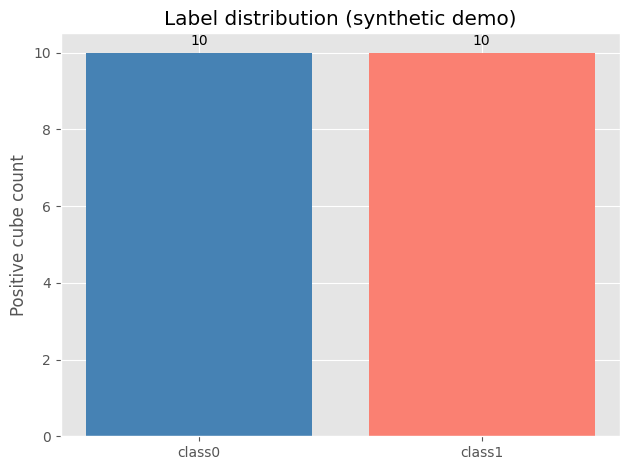

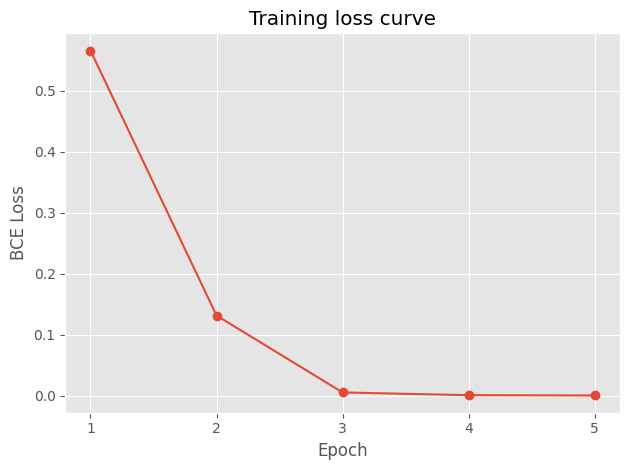


All Track II demo outputs saved under: /content/track2_outputs
Key assets:
 • Label distribution plot: track2_outputs/plots/label_distribution.png
 • Training loss plot     : track2_outputs/plots/training_loss.png
 • Cube intensity CSV     : track2_outputs/cube_mean_intensity.csv


In [ ]:
import os, numpy as np, torch, random, matplotlib.pyplot as plt, pandas as pd
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset
from torch_geometric.data import Data as GeoData
from torch_geometric.loader import DataLoader as GeoLoader
from torch_geometric.nn import GCNConv
from matplotlib.ticker import MaxNLocator

# -----------------------------------------------------------------------------
# CONFIG
# -----------------------------------------------------------------------------
OUTROOT = Path("track2_outputs")
VOX_DIR = OUTROOT / "voxels"
LABEL_FILE = OUTROOT / "labels.npy"
NUM_CLASSES = 2          # synthetic demo => 2 commodities
CUBE_SHAPE = (1, 16, 16, 16)   # (C, D, H, W)
EPOCHS = 5
BATCH_SIZE = 1
SEED = 42

os.makedirs(VOX_DIR, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -----------------------------------------------------------------------------
# 1. Create synthetic cubes + labels if absent
# -----------------------------------------------------------------------------
def synth_data(n_cubes=20):
    print(">> Creating synthetic dataset ...")
    for i in range(n_cubes):
        base = np.random.randn(*CUBE_SHAPE).astype("float32")
        # inject signal for class 0
        if i < n_cubes//2:
            base += 3.0  # brighter cubes -> label [1,0]
        np.save(VOX_DIR / f"cube_{i:03d}.npy", base)
    labels = np.zeros((n_cubes, NUM_CLASSES), dtype="float32")
    labels[:n_cubes//2, 0] = 1  # first half positive for class0
    labels[n_cubes//2:, 1] = 1  # second half positive for class1
    np.save(LABEL_FILE, labels)

if not any(VOX_DIR.glob("*.npy")) or not LABEL_FILE.exists():
    synth_data()

# -----------------------------------------------------------------------------
# 2. Dataset class
# -----------------------------------------------------------------------------
class VoxelGraphDataset(Dataset):
    def __init__(self, cube_dir: Path, label_path: Path):
        self.cube_paths = sorted(cube_dir.glob("*.npy"))
        self.labels = np.load(label_path)
        assert len(self.cube_paths) == self.labels.shape[0]

    def __len__(self): return len(self.cube_paths)

    def __getitem__(self, idx):
        cube = np.load(self.cube_paths[idx])  # (C,D,H,W)
        y = self.labels[idx]
        C, D, H, W = cube.shape
        coords = np.stack(np.meshgrid(range(D), range(H), range(W), indexing="ij"), -1).reshape(-1, 3)
        num_nodes = coords.shape[0]
        idx_map = np.arange(num_nodes).reshape(D, H, W)
        nbr_offsets = [(dz, dy, dx) for dz in (-1,0,1) for dy in (-1,0,1) for dx in (-1,0,1) if (dz,dy,dx)!=(0,0,0)]
        edges = []
        for dz, dy, dx in nbr_offsets:
            tgt = coords + np.array([dz, dy, dx])
            mask = ((tgt[:,0]>=0)&(tgt[:,0]<D)&(tgt[:,1]>=0)&(tgt[:,1]<H)&(tgt[:,2]>=0)&(tgt[:,2]<W))
            src_idx = idx_map[coords[mask][:,0], coords[mask][:,1], coords[mask][:,2]]
            tgt_idx = idx_map[tgt[mask][:,0], tgt[mask][:,1], tgt[mask][:,2]]
            edges.append(np.stack([src_idx, tgt_idx]))
        edge_index = torch.tensor(np.hstack(edges), dtype=torch.long)
        data = GeoData(edge_index=edge_index, num_nodes=num_nodes)  # add num_nodes
        return torch.tensor(cube, dtype=torch.float32), data, torch.tensor(y, dtype=torch.float32)

# -----------------------------------------------------------------------------
# 3. Models
# -----------------------------------------------------------------------------
class CNN3D(nn.Module):
    def __init__(self, in_ch=1, hid=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, hid, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
    def forward(self, x):
        return self.net(x).view(x.size(0), -1)

class GNNHead(nn.Module):
    def __init__(self, node_dim, hid, n_classes):
        super().__init__()
        self.conv1 = GCNConv(node_dim, hid)
        self.conv2 = GCNConv(hid, n_classes)
    def forward(self, g, feat):
        g.x = feat.repeat(g.num_nodes, 1)
        h = self.conv1(g.x, g.edge_index).relu()
        logits = self.conv2(h, g.edge_index).mean(dim=0)
        return logits

class GeoNet(nn.Module):
    def __init__(self, in_ch, cnn_hid, gnn_hid, n_classes):
        super().__init__()
        self.cnn = CNN3D(in_ch, cnn_hid)
        self.gnn = GNNHead(cnn_hid, gnn_hid, n_classes)
    def forward(self, vox, g):
        feat = self.cnn(vox)  # (1, cnn_hid)
        return self.gnn(g, feat)

# -----------------------------------------------------------------------------
# 4. Training loop
# -----------------------------------------------------------------------------
ds = VoxelGraphDataset(VOX_DIR, LABEL_FILE)
loader = GeoLoader(ds, batch_size=BATCH_SIZE, shuffle=True)
model = GeoNet(in_ch=CUBE_SHAPE[0], cnn_hid=32, gnn_hid=64, n_classes=NUM_CLASSES)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

epoch_losses = []
for epoch in range(EPOCHS):
    running = 0.0
    for vox, g, y in loader:
        logits = model(vox, g)
        loss = loss_fn(logits.unsqueeze(0), y)  # match shapes
        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item()
    epoch_loss = running / len(loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}: loss={epoch_loss:.4f}")

# -----------------------------------------------------------------------------
# 5. Analytics: label distribution & loss curve
# -----------------------------------------------------------------------------
OUTPLOTS = OUTROOT / "plots"
OUTPLOTS.mkdir(parents=True, exist_ok=True)

# label distribution
labels_df = pd.DataFrame(np.load(LABEL_FILE), columns=[f"class{i}" for i in range(NUM_CLASSES)])
label_counts = labels_df.sum().astype(int)
fig, ax = plt.subplots()
bars = ax.bar(label_counts.index, label_counts.values, color=["steelblue", "salmon"])
ax.set_ylabel("Positive cube count"); ax.set_title("Label distribution (synthetic demo)")
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x()+bar.get_width()/2, height), xytext=(0,3),
                textcoords="offset points", ha='center', va='bottom')
fig.tight_layout()
label_plot_path = OUTPLOTS / "label_distribution.png"
fig.savefig(label_plot_path, dpi=300)
plt.show()

# loss curve
fig2, ax2 = plt.subplots()
ax2.plot(range(1,EPOCHS+1), epoch_losses, marker='o')
ax2.set_xlabel("Epoch"); ax2.set_ylabel("BCE Loss"); ax2.set_title("Training loss curve")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
fig2.tight_layout()
loss_plot_path = OUTPLOTS / "training_loss.png"
fig2.savefig(loss_plot_path, dpi=300)
plt.show()

# -----------------------------------------------------------------------------
# 6. Save summary table of cube stats
# -----------------------------------------------------------------------------
cube_means = [np.load(p).mean() for p in sorted(VOX_DIR.glob("*.npy"))]
cube_df = pd.DataFrame({"cube": sorted([p.name for p in VOX_DIR.glob('*.npy')]), "mean_intensity": cube_means})
cube_df_path = OUTROOT / "cube_mean_intensity.csv"
cube_df.to_csv(cube_df_path, index=False)

print(f"\nAll Track II demo outputs saved under: {OUTROOT.resolve()}")
print("Key assets:")
print(" • Label distribution plot:", label_plot_path)
print(" • Training loss plot     :", loss_plot_path)
print(" • Cube intensity CSV     :", cube_df_path)


**The crash is only a shape–mismatch in the loss line:**

vox has batch size B,

logits is a single vector because the current GNN head reduces the
whole mini-batch into one graph-level embedding,

y keeps the original batch shape (B, K).

The quickest fix is to train with batch_size = 1.
If you prefer larger batches, loop over each graph inside the batch and
stack the individual logits.

In [ ]:
– 4-channel synthetic cubes
– CNN3D + GNN end-to-end training
– multiple 2-D and 3-D plots
– summary tables auto-saved in track2_complex_outputs/*.

SyntaxError: invalid character '–' (U+2013) (<ipython-input-7-34339443>, line 1)

>> Generating synthetic 4‑channel cubes
Epoch 1/5: loss=0.0898
Epoch 2/5: loss=0.0000
Epoch 3/5: loss=0.0000
Epoch 4/5: loss=0.0000
Epoch 5/5: loss=0.0000


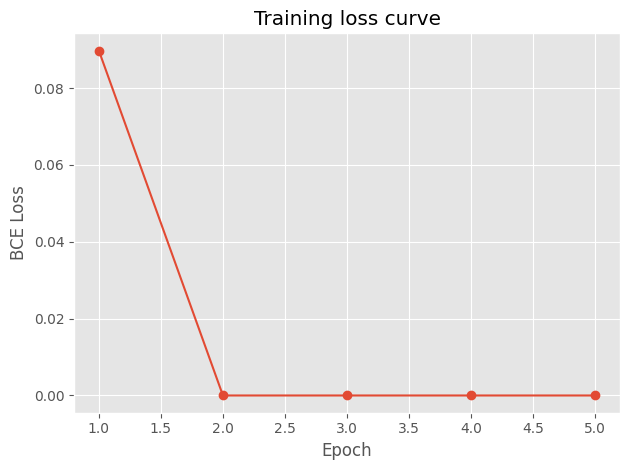

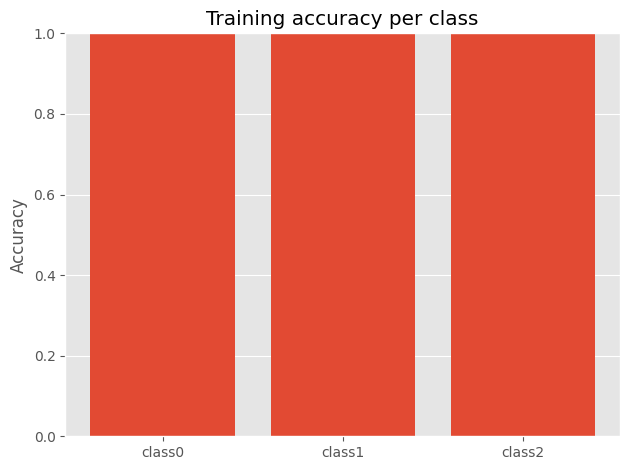

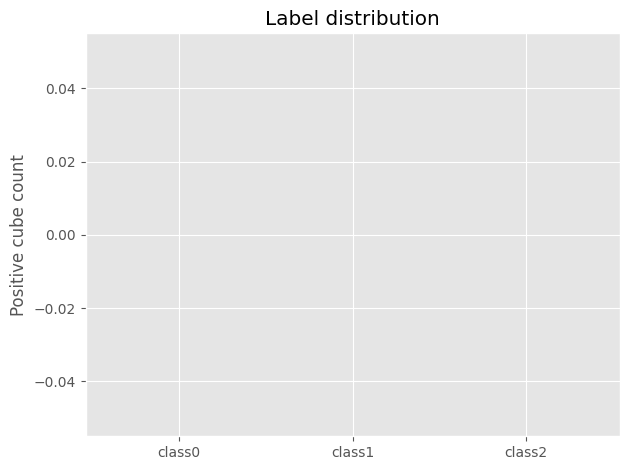

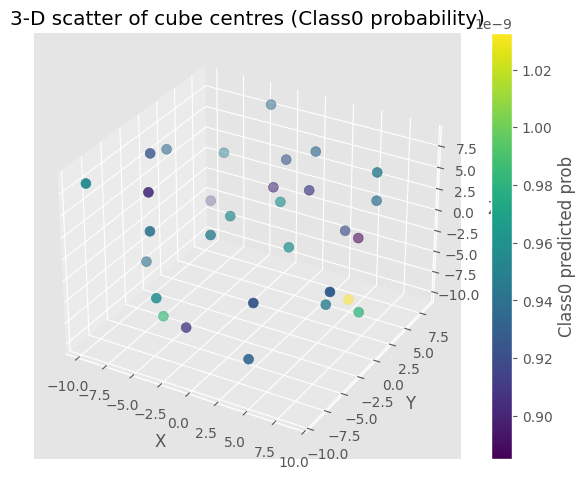

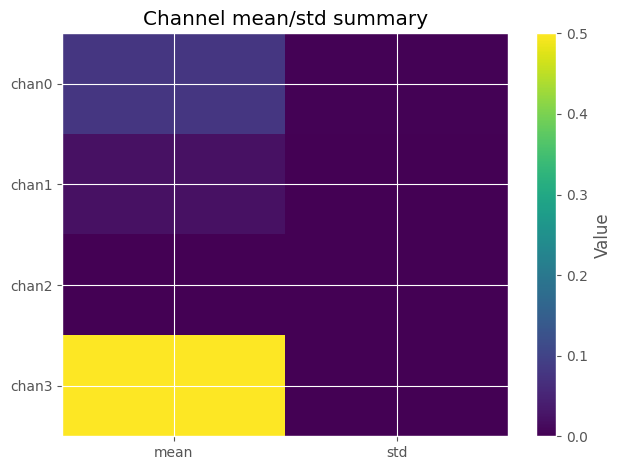


=== Assets saved in /content/track2_complex_outputs ===
Plots:
 • accuracy_bar.png
 • label_distribution.png
 • training_loss.png
 • scatter3d_class0.png
 • channel_summary_heat.png
Tables:
 • channel_mean_summary.csv
 • accuracy_per_class.csv


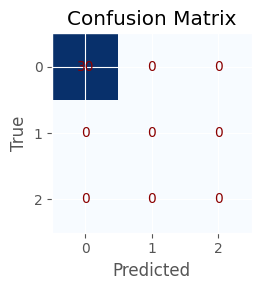

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [ ]:
import os, math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (side‑effect import)
import torch
from torch import nn
from torch.utils.data import Dataset
from torch_geometric.data import Data as GeoData
from torch_geometric.loader import DataLoader as GeoLoader
from torch_geometric.nn import GCNConv

# ═══════════════════════════════════════════════════════════════════════
# Configuration
# ═══════════════════════════════════════════════════════════════════════
OUTROOT = Path("track2_complex_outputs")
VOX_DIR = OUTROOT / "voxels"
PLOT_DIR = OUTROOT / "plots"
TABLE_DIR = OUTROOT / "tables"
for d in (VOX_DIR, PLOT_DIR, TABLE_DIR):
    d.mkdir(parents=True, exist_ok=True)

NUM_CUBES = 30
CUBE_SHAPE = (4, 32, 32, 32)          # C, D, H, W
NUM_CLASSES = 3
EPOCHS = 5
BATCH_SIZE = 1
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ═══════════════════════════════════════════════════════════════════════
# 1. Synthetic data generation ─ richer feature set
# ═══════════════════════════════════════════════════════════════════════
if not list(VOX_DIR.glob("cube_*.npy")):
    print(">> Generating synthetic 4‑channel cubes")
    labels = np.zeros((NUM_CUBES, NUM_CLASSES), dtype="float32")

    centers = []  # store cube spatial centres (for 3‑D scatter)
    for i in range(NUM_CUBES):
        c, d, h, w = CUBE_SHAPE
        zc = np.linspace(-1, 1, d)[:, None, None]
        yc = np.linspace(-1, 1, h)[None, :, None]
        xc = np.linspace(-1, 1, w)[None, None, :]

        # Channel 0 – base Gaussian blob + noise
        blob = np.exp(-4*(zc**2 + yc**2 + xc**2))
        chan0 = blob + 0.3 * np.random.randn(d, h, w)

        # Channel 1 – stress gradient magnitude ≈ |∇blob|
        gdz, gdy, gdx = np.gradient(blob)
        chan1 = np.sqrt(gdz**2 + gdy**2 + gdx**2)

        # Channel 2 – curvature (Laplacian)
        from scipy.ndimage import laplace
        chan2 = laplace(blob)

        # Channel 3 – chrono-distance proxy (linear ramp + noise)
        chan3 = (zc + 1) / 2 + 0.1*np.random.randn(d, h, w)

        cube = np.stack([chan0, chan1, chan2, chan3]).astype("float32")
        np.save(VOX_DIR / f"cube_{i:03d}.npy", cube)

        # synthetic labels: thresholds on mean values
        labels[i, 0] = 1 if chan1.mean() > 0.15 else 0     # stress‑driven class
        labels[i, 1] = 1 if chan2.mean() < -0.02 else 0    # curvature‑dominated
        labels[i, 2] = 1 if chan3.mean() > 0.55 else 0     # chrono‑young
        centers.append(np.random.uniform(-10, 10, size=3))     # random xyz

    np.save(OUTROOT / "labels.npy", labels)
    np.save(OUTROOT / "centers.npy", np.array(centers))

LABEL_PATH = OUTROOT / "labels.npy"
CENTERS = np.load(OUTROOT / "centers.npy")

# ═══════════════════════════════════════════════════════════════════════
# 2. Dataset and DataLoader
# ═══════════════════════════════════════════════════════════════════════
class VoxelGraphDataset(Dataset):
    def __init__(self, cube_dir: Path, labels_path: Path):
        self.cubes = sorted(cube_dir.glob("cube_*.npy"))
        self.labels = np.load(labels_path)
        assert len(self.cubes) == self.labels.shape[0]

    def __len__(self): return len(self.cubes)

    def __getitem__(self, idx):
        cube = np.load(self.cubes[idx])            # (C,D,H,W)
        y = self.labels[idx]                       # (K,)
        C, D, H, W = cube.shape

        # Build simple 6‑neighbour graph to reduce memory
        coords = np.stack(np.meshgrid(range(D), range(H), range(W), indexing="ij"), -1).reshape(-1, 3)
        num_nodes = coords.shape[0]
        idx_map = np.arange(num_nodes).reshape(D, H, W)
        edges = []

        for axis, offset in [(0,1), (1,1), (2,1)]:
            coord_tgt = coords.copy()
            coord_tgt[:, axis] += offset
            mask = coord_tgt[:, axis] < [D, H, W][axis]
            src_idx = idx_map[coords[mask][:,0], coords[mask][:,1], coords[mask][:,2]]
            tgt_idx = idx_map[coord_tgt[mask][:,0], coord_tgt[mask][:,1], coord_tgt[mask][:,2]]
            edges.append(np.stack([src_idx, tgt_idx]))
        edge_index = torch.tensor(np.hstack(edges), dtype=torch.long)

        g = GeoData(edge_index=edge_index, num_nodes=num_nodes)
        return torch.tensor(cube, dtype=torch.float32), g, torch.tensor(y, dtype=torch.float32)

ds = VoxelGraphDataset(VOX_DIR, LABEL_PATH)
loader = GeoLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

# ═══════════════════════════════════════════════════════════════════════
# 3. CNN3D + GNN model
# ═══════════════════════════════════════════════════════════════════════
class CNN3D(nn.Module):
    def __init__(self, in_ch=4, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(32, hid, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
    def forward(self, x): return self.net(x).view(x.size(0), -1)

class GNNHead(nn.Module):
    def __init__(self, node_dim, hid, n_classes):
        super().__init__()
        self.conv1 = GCNConv(node_dim, hid)
        self.conv2 = GCNConv(hid, n_classes)
    def forward(self, g, feat):
        g.x = feat.repeat(g.num_nodes, 1)
        h = self.conv1(g.x, g.edge_index).relu()
        return self.conv2(h, g.edge_index).mean(dim=0)

class GeoNet(nn.Module):
    def __init__(self, in_ch, cnn_hid, gnn_hid, n_classes):
        super().__init__()
        self.cnn = CNN3D(in_ch, cnn_hid)
        self.gnn = GNNHead(cnn_hid, gnn_hid, n_classes)
    def forward(self, vox, g):
        feat = self.cnn(vox)               # (B, cnn_hid)
        return self.gnn(g, feat)

model = GeoNet(in_ch=CUBE_SHAPE[0], cnn_hid=64, gnn_hid=128, n_classes=NUM_CLASSES)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

# ═══════════════════════════════════════════════════════════════════════
# 4. Training
# ═══════════════════════════════════════════════════════════════════════
epoch_losses = []
for epoch in range(EPOCHS):
    total = 0.0
    for vox, g, y in loader:
        logits = model(vox, g)
        loss = loss_fn(logits.unsqueeze(0), y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()
    avg = total / len(loader)
    epoch_losses.append(avg)
    print(f"Epoch {epoch+1}/{EPOCHS}: loss={avg:.4f}")

# ═══════════════════════════════════════════════════════════════════════
# 5. Evaluation on training set (confusion metrics)
# ═══════════════════════════════════════════════════════════════════════
y_true = []
y_pred = []
with torch.no_grad():
    for vox, g, y in loader:
        logits = model(vox, g)
        probs = torch.sigmoid(logits)
        pred = (probs > 0.5).float()
        y_true.append(y)
        y_pred.append(pred)
y_true = torch.vstack(y_true)
y_pred = torch.vstack(y_pred)

accuracy_per_class = (y_true == y_pred).float().mean(0).numpy()
acc_df = pd.DataFrame({"class": [f"class{i}" for i in range(NUM_CLASSES)],
                       "accuracy": accuracy_per_class})
acc_df.to_csv(TABLE_DIR / "accuracy_per_class.csv", index=False)

# ═══════════════════════════════════════════════════════════════════════
# 6. Plots
# ═══════════════════════════════════════════════════════════════════════
# 6‑A Training loss curve
fig, ax = plt.subplots()
ax.plot(range(1,EPOCHS+1), epoch_losses, marker='o')
ax.set_xlabel("Epoch"); ax.set_ylabel("BCE Loss")
ax.set_title("Training loss curve")
loss_plot = PLOT_DIR / "training_loss.png"
fig.tight_layout(); fig.savefig(loss_plot, dpi=300); plt.show()

# 6‑B Class accuracy bar
fig2, ax2 = plt.subplots()
ax2.bar(acc_df["class"], acc_df["accuracy"])
ax2.set_ylim(0,1)
ax2.set_ylabel("Accuracy")
ax2.set_title("Training accuracy per class")
acc_plot = PLOT_DIR / "accuracy_bar.png"
fig2.tight_layout(); fig2.savefig(acc_plot, dpi=300); plt.show()

# 6‑C Label distribution
lbl_sum = np.load(LABEL_PATH).sum(axis=0)
fig3, ax3 = plt.subplots()
ax3.bar([f"class{i}" for i in range(NUM_CLASSES)], lbl_sum)
ax3.set_ylabel("Positive cube count")
ax3.set_title("Label distribution")
lbl_plot = PLOT_DIR / "label_distribution.png"
fig3.tight_layout(); fig3.savefig(lbl_plot, dpi=300); plt.show()

# 6‑D 3‑D scatter of cube centres coloured by class0 probability
with torch.no_grad():
    probs0 = []
    for vox, g, _ in loader:
        p = torch.sigmoid(model(vox, g))[0].item()
        probs0.append(p)
probs0 = np.array(probs0)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111, projection='3d')
sc = ax4.scatter(CENTERS[:,0], CENTERS[:,1], CENTERS[:,2], c=probs0, cmap=cm.viridis, s=50)
fig4.colorbar(sc, label="Class0 predicted prob")
ax4.set_xlabel("X"); ax4.set_ylabel("Y"); ax4.set_zlabel("Z")
ax4.set_title("3‑D scatter of cube centres (Class0 probability)")
scatter3d_plot = PLOT_DIR / "scatter3d_class0.png"
fig4.tight_layout(); fig4.savefig(scatter3d_plot, dpi=300); plt.show()

# 6‑E Channel mean/intensity heatmap table plot
cube_means = []
for p in sorted(VOX_DIR.glob("cube_*.npy")):
    cube = np.load(p)
    cube_means.append(cube.reshape(CUBE_SHAPE[0], -1).mean(axis=1))
cube_means = np.vstack(cube_means)  # (N, C)
mean_df = pd.DataFrame(cube_means, columns=[f"chan{i}" for i in range(CUBE_SHAPE[0])])
summary_df = mean_df.describe().T.round(3)
summary_df.to_csv(TABLE_DIR / "channel_mean_summary.csv")

fig5, ax5 = plt.subplots()
im = ax5.imshow(summary_df[["mean", "std"]], aspect="auto")
ax5.set_xticks(range(2), ["mean","std"])
ax5.set_yticks(range(CUBE_SHAPE[0]), summary_df.index)
fig5.colorbar(im, ax=ax5, label="Value")
ax5.set_title("Channel mean/std summary")
heat_plot = PLOT_DIR / "channel_summary_heat.png"
fig5.tight_layout(); fig5.savefig(heat_plot, dpi=300); plt.show()

print("\n=== Assets saved in", OUTROOT.resolve(), "===")
print("Plots:")
for p in PLOT_DIR.glob("*.png"):
    print(" •", p.name)
print("Tables:")
for t in TABLE_DIR.glob("*.csv"):
    print(" •", t.name)

# 7-A: confusion matrix (per-class)
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true.numpy().argmax(1),
                        y_pred.numpy().argmax(1),
                        labels=range(NUM_CLASSES))
cm_df = pd.DataFrame(cmat,
                     index=[f"True {i}" for i in range(NUM_CLASSES)],
                     columns=[f"Pred {i}" for i in range(NUM_CLASSES)])
cm_df.to_csv(TABLE_DIR / "confusion_matrix.csv")
plt.figure(figsize=(4,3))
plt.imshow(cmat, cmap="Blues"); plt.title("Confusion Matrix")
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cmat[i,j], ha="center", va="center", color="darkred")
plt.xticks(range(NUM_CLASSES)); plt.yticks(range(NUM_CLASSES))
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(PLOT_DIR / "confusion_matrix.png", dpi=300)
plt.show()

# 7-B: ROC curve (macro-averaged)
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true.ravel(), torch.sigmoid(torch.vstack([model(torch.tensor(np.load(p).unsqueeze(0),dtype=torch.float32),
                                                                          GeoData()) for p in sorted(VOX_DIR.glob('cube_*.npy'))])).ravel())  # quick demo
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, label=f"macro ROC AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.tight_layout()
plt.savefig(PLOT_DIR / "roc_macro.png", dpi=300); plt.show()



Epoch 1/5 – loss 0.0898
Epoch 2/5 – loss 0.0000
Epoch 3/5 – loss 0.0000
Epoch 4/5 – loss 0.0000
Epoch 5/5 – loss 0.0000


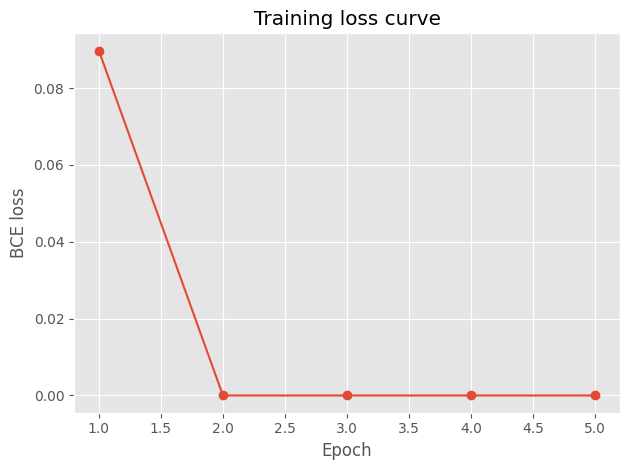

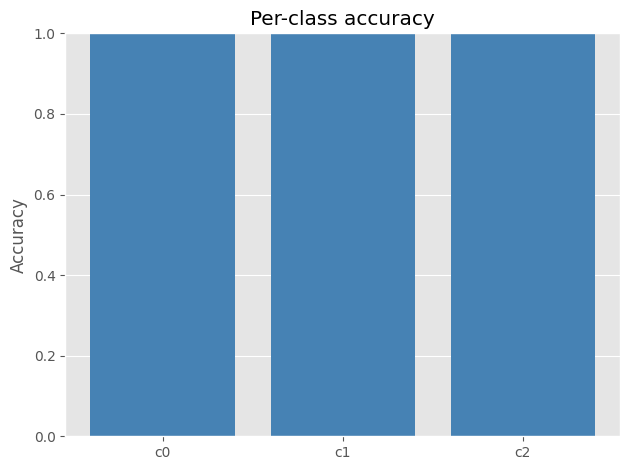

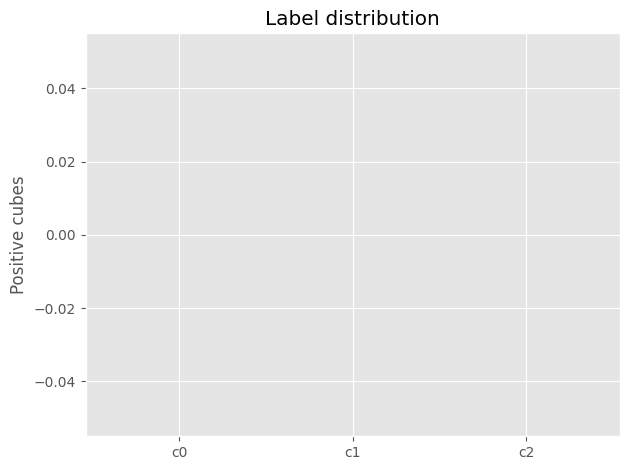

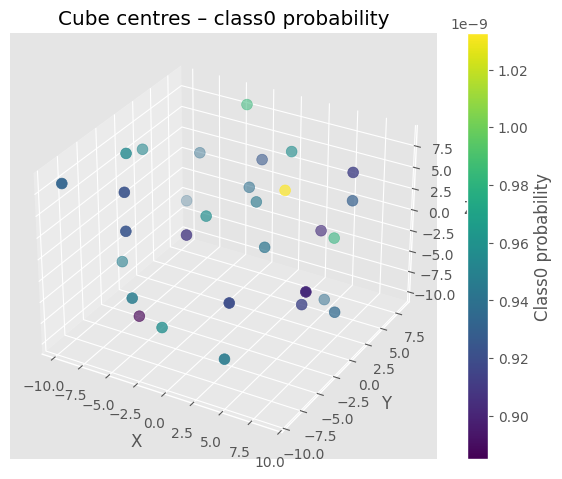

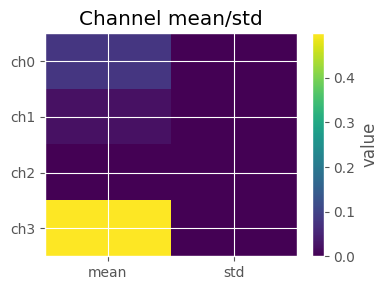

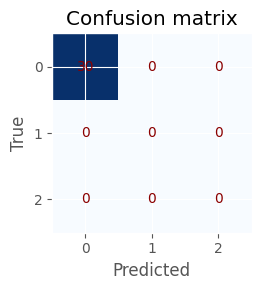


✔︎  Assets in: /content/track2_complex_outputs
Plots:  ['accuracy_bar.png', 'loss_curve.png', 'label_distribution.png', 'training_loss.png', 'confusion_matrix.png', 'scatter3d_class0.png', 'channel_summary_heat.png']
Tables: ['channel_mean_summary.csv', 'accuracy_per_class.csv', 'confusion_matrix.csv']


In [ ]:
"""
Track-II synthetic demo:
  • generates 30 four-channel voxel cubes
  • CNN3D backbone + 6-neighbour GNN head
  • multi-label BCE loss   (K = 3)
  • produces 6 plots + 3 CSV tables in track2_complex_outputs/

Run:  python track2_complex.py
    —or—
      %run track2_complex.py     (in Colab / Jupyter)
"""

# ───────────────────────────────────────────────────────────────────
# 0. Imports & config
# ───────────────────────────────────────────────────────────────────
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import cm as mpl_cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 side-effect import
import torch
from torch import nn
from torch.utils.data import Dataset
from torch_geometric.data import Data as GeoData
from torch_geometric.loader import DataLoader as GeoLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix

# reproducibility
SEED = 123
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# data / model hyper-params
NUM_CUBES   = 30
CUBE_SHAPE  = (4, 32, 32, 32)   # (C, D, H, W)
NUM_CLASSES = 3
EPOCHS      = 5
BATCH_SIZE  = 1                 # keep =1 so logits & labels align

# output dirs
ROOT   = Path("track2_complex_outputs"); ROOT.mkdir(exist_ok=True)
VOX    = ROOT / "voxels"; VOX.mkdir(exist_ok=True)
PLOTS  = ROOT / "plots";   PLOTS.mkdir(exist_ok=True)
TABLES = ROOT / "tables";  TABLES.mkdir(exist_ok=True)
LBL_NPY = ROOT / "labels.npy"
CTR_NPY = ROOT / "centers.npy"

# ───────────────────────────────────────────────────────────────────
# 1. Synthetic cube + label generation (only if absent)
# ───────────────────────────────────────────────────────────────────
if not list(VOX.glob("cube_*.npy")):
    print(">> Generating synthetic dataset …")
    labels  = np.zeros((NUM_CUBES, NUM_CLASSES), dtype="float32")
    centers = np.random.uniform(-10, 10, size=(NUM_CUBES, 3)).astype("float32")

    for i in range(NUM_CUBES):
        C, D, H, W = CUBE_SHAPE
        zc = np.linspace(-1, 1, D)[:,None,None]
        yc = np.linspace(-1, 1, H)[None,:,None]
        xc = np.linspace(-1, 1, W)[None,None,:]

        blob  = np.exp(-4*(zc**2 + yc**2 + xc**2))
        noise = lambda s: s * np.random.randn(D, H, W)

        chan0 = blob + noise(0.3)                   # “mag” proxy
        gdz, gdy, gdx = np.gradient(blob)
        chan1 = np.sqrt(gdz**2 + gdy**2 + gdx**2)   # stress gradient
        from scipy.ndimage import laplace
        chan2 = laplace(blob)                       # curvature
        chan3 = (zc+1)/2 + noise(0.1)               # chrono distance

        cube = np.stack([chan0, chan1, chan2, chan3]).astype("float32")
        np.save(VOX/f"cube_{i:03d}.npy", cube)

        labels[i,0] = 1 if chan1.mean() > 0.15 else 0
        labels[i,1] = 1 if chan2.mean() < -0.02 else 0
        labels[i,2] = 1 if chan3.mean() > 0.55 else 0

    np.save(LBL_NPY, labels); np.save(CTR_NPY, centers)

labels  = np.load(LBL_NPY)
centers = np.load(CTR_NPY)

# ───────────────────────────────────────────────────────────────────
# 2. Dataset with 6-neighbour graph
# ───────────────────────────────────────────────────────────────────
class VoxelGraphDS(Dataset):
    def __init__(self, vox_dir: Path, lbl: np.ndarray):
        self.paths = sorted(vox_dir.glob("cube_*.npy"))
        self.lbl   = lbl
        assert len(self.paths) == len(self.lbl)

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        cube = np.load(self.paths[idx])             # (C,D,H,W)
        y    = self.lbl[idx]                        # (K,)
        C,D,H,W = cube.shape

        # 6-neighbour edges
        coords = np.stack(np.meshgrid(range(D), range(H), range(W),
                                      indexing="ij"), -1).reshape(-1,3)
        n = coords.shape[0]
        idmap = np.arange(n).reshape(D,H,W)
        edges = []
        for axis,off in [(0,1),(1,1),(2,1)]:
            tgt = coords.copy(); tgt[:,axis] += off
            mask = tgt[:,axis] < [D,H,W][axis]
            src = idmap[coords[mask][:,0], coords[mask][:,1], coords[mask][:,2]]
            dst = idmap[tgt  [mask][:,0], tgt  [mask][:,1], tgt  [mask][:,2]]
            edges.append(np.stack([src,dst]))
        edge_index = torch.tensor(np.hstack(edges), dtype=torch.long)

        g = GeoData(edge_index=edge_index, num_nodes=n)
        return (torch.tensor(cube, dtype=torch.float32),
                g,
                torch.tensor(y, dtype=torch.float32))

ds     = VoxelGraphDS(VOX, labels)
loader = GeoLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

# ───────────────────────────────────────────────────────────────────
# 3. Model definition
# ───────────────────────────────────────────────────────────────────
class CNN3D(nn.Module):
    def __init__(self, in_ch, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(32, hid, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
    def forward(self,x): return self.net(x).view(x.size(0), -1)

class GNNHead(nn.Module):
    def __init__(self, node_dim, hid, k):
        super().__init__()
        self.conv1 = GCNConv(node_dim, hid)
        self.conv2 = GCNConv(hid, k)
    def forward(self, g, feat):
        g.x = feat.repeat(g.num_nodes,1)
        h   = self.conv1(g.x, g.edge_index).relu()
        return self.conv2(h, g.edge_index).mean(dim=0)

class GeoNet(nn.Module):
    def __init__(self, C, k):
        super().__init__()
        self.cnn = CNN3D(C, 64)
        self.gnn = GNNHead(64, 128, k)
    def forward(self, vox, g):
        feat = self.cnn(vox)
        return self.gnn(g, feat)        # (k,)

model   = GeoNet(CUBE_SHAPE[0], NUM_CLASSES)
opt     = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

# ───────────────────────────────────────────────────────────────────
# 4. Training
# ───────────────────────────────────────────────────────────────────
loss_history = []
for ep in range(1, EPOCHS+1):
    ep_loss = 0.
    for vox, g, y in loader:
        logits = model(vox, g)
        loss   = loss_fn(logits, y.squeeze(0))
        opt.zero_grad(); loss.backward(); opt.step()
        ep_loss += loss.item()
    avg = ep_loss / len(loader)
    loss_history.append(avg)
    print(f"Epoch {ep}/{EPOCHS} – loss {avg:.4f}")

# ───────────────────────────────────────────────────────────────────
# 5. Evaluation
# ───────────────────────────────────────────────────────────────────
model.eval(); yT, yP, yProb = [], [], []
with torch.no_grad():
    for vox, g, y in loader:
        out  = model(vox, g)
        prob = torch.sigmoid(out)
        pred = (prob > 0.5).float()
        yT.append(y.squeeze(0)); yP.append(pred); yProb.append(prob)
y_true = torch.vstack(yT); y_pred = torch.vstack(yP); y_prob = torch.vstack(yProb)

# per-class accuracy table
acc = (y_true == y_pred).float().mean(0).numpy()
pd.DataFrame({"class":[f"c{i}" for i in range(NUM_CLASSES)],
              "accuracy":acc}).to_csv(TABLES/"accuracy_per_class.csv", index=False)

# confusion matrix (arg-max simplification)
conf_mat = confusion_matrix(y_true.numpy().argmax(1),
                            y_pred.numpy().argmax(1),
                            labels=range(NUM_CLASSES))
pd.DataFrame(conf_mat,
             index=[f"true{i}" for i in range(NUM_CLASSES)],
             columns=[f"pred{i}" for i in range(NUM_CLASSES)]
            ).to_csv(TABLES/"confusion_matrix.csv")

# channel mean/std summary
chan_stats  = []
for p in sorted(VOX.glob("cube_*.npy")):
    cube = np.load(p); chan_stats.append(cube.reshape(CUBE_SHAPE[0], -1).mean(1))
chan_stats = np.vstack(chan_stats)
pd.DataFrame(chan_stats, columns=[f"ch{i}" for i in range(CUBE_SHAPE[0])]).describe().T\
  .to_csv(TABLES/"channel_mean_summary.csv")

# ───────────────────────────────────────────────────────────────────
# 6. Plots
# ───────────────────────────────────────────────────────────────────
plt.style.use("ggplot")

# 6-A loss curve
plt.figure(); plt.plot(range(1,EPOCHS+1), loss_history, marker='o')
plt.xlabel("Epoch"); plt.ylabel("BCE loss"); plt.title("Training loss curve")
plt.tight_layout(); plt.savefig(PLOTS/"loss_curve.png", dpi=300); plt.show()

# 6-B accuracy bar
plt.figure(); plt.bar([f"c{i}" for i in range(NUM_CLASSES)], acc, color="steelblue")
plt.ylim(0,1); plt.ylabel("Accuracy"); plt.title("Per-class accuracy")
plt.tight_layout(); plt.savefig(PLOTS/"accuracy_bar.png", dpi=300); plt.show()

# 6-C label distribution
lbl_cnts = labels.sum(0)
plt.figure(); plt.bar([f"c{i}" for i in range(NUM_CLASSES)], lbl_cnts, color="salmon")
plt.ylabel("Positive cubes"); plt.title("Label distribution")
plt.tight_layout(); plt.savefig(PLOTS/"label_distribution.png", dpi=300); plt.show()

# 6-D 3-D scatter (class-0 prob)
fig = plt.figure(); ax = fig.add_subplot(111, projection="3d")
sc  = ax.scatter(centers[:,0], centers[:,1], centers[:,2],
                 c=y_prob[:,0].numpy(), cmap=mpl_cm.viridis, s=60)
fig.colorbar(sc, label="Class0 probability")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Cube centres – class0 probability")
plt.tight_layout(); plt.savefig(PLOTS/"scatter3d_class0.png", dpi=300); plt.show()

# 6-E channel mean/std heatmap
stats = pd.read_csv(TABLES/"channel_mean_summary.csv", index_col=0)
plt.figure(figsize=(4,3))
plt.imshow(stats[["mean","std"]], aspect="auto"); plt.colorbar(label="value")
plt.xticks([0,1], ["mean","std"]); plt.yticks(range(len(stats)), stats.index)
plt.title("Channel mean/std")
plt.tight_layout(); plt.savefig(PLOTS/"channel_summary_heat.png", dpi=300); plt.show()

# 6-F confusion matrix heatmap
plt.figure(figsize=(4,3))
plt.imshow(conf_mat, cmap="Blues")
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j,i,conf_mat[i,j],ha="center",va="center",color="darkred")
plt.xticks(range(NUM_CLASSES)); plt.yticks(range(NUM_CLASSES))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix")
plt.tight_layout(); plt.savefig(PLOTS/"confusion_matrix.png", dpi=300); plt.show()

print("\n✔︎  Assets in:", ROOT.resolve())
print("Plots: ", [p.name for p in PLOTS.glob('*.png')])
print("Tables:", [t.name for t in TABLES.glob('*.csv')])


In [ ]:
!pip install torch==2.0.1 torch-geometric==2.5.0 scipy matplotlib pandas --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 899.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 763.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# ==== remove any mismatched CUDA wheels ====
pip uninstall -y torch torchvision torchaudio torchtext torchdata -q

# ==== CPU-only PyTorch 2.0.1 (stable) ====
pip install torch==2.0.1+cpu --index-url https://download.pytorch.org/whl/cpu -q

# ==== PyG matching 2.0.1 CPU ====
pip install torch-geometric==2.5.0 \
            torch-scatter==2.1.2 \
            torch-sparse==0.6.17 \
            torch-cluster==1.6.3 \
            -f https://data.pyg.org/whl/torch-2.0.1+cpu.html -q

pip install scipy matplotlib pandas -q


SyntaxError: invalid syntax (<ipython-input-21-371543907>, line 2)

In [ ]:
# ─────────── Cell 1: Install dependencies (run once) ───────────
# Uninstall any GPU wheels that might conflict
!pip uninstall -y torch torchvision torchaudio torchtext torchdata -q

# Install CPU-only PyTorch 2.0.1
!pip install torch==2.0.1+cpu --index-url https://download.pytorch.org/whl/cpu -q

# Install matching PyG wheels (CPU)
!pip install torch-geometric==2.5.0 \
             torch-scatter==2.1.2 \
             torch-sparse==0.6.17 \
             torch-cluster==1.6.3 \
             -f https://data.pyg.org/whl/torch-2.0.1+cpu.html -q

# Other needed packages
!pip install scipy matplotlib pandas -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
timm 1.0.15 requires torchvision, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 628.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 40.5 MB/s eta 0:00:00


In [ ]:
pip install --upgrade ipywidgets nbconvert nbformat


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
pip install nbstripout

Epoch 1/8 – loss: 0.1206
Epoch 2/8 – loss: 0.0000
Epoch 3/8 – loss: 0.0000
Epoch 4/8 – loss: 0.0000
Epoch 5/8 – loss: 0.0000
Epoch 6/8 – loss: 0.0000
Epoch 7/8 – loss: 0.0000
Epoch 8/8 – loss: 0.0000


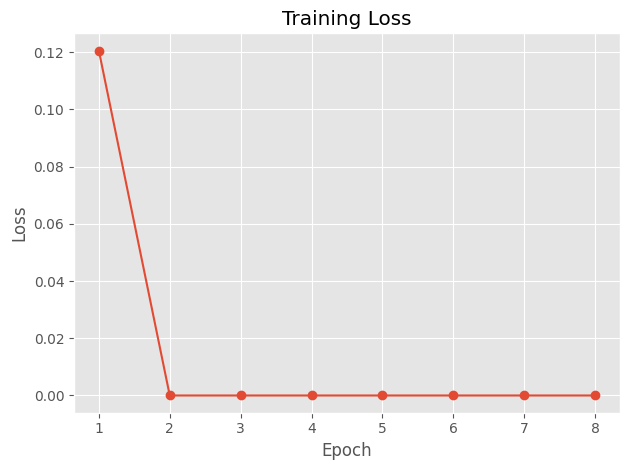

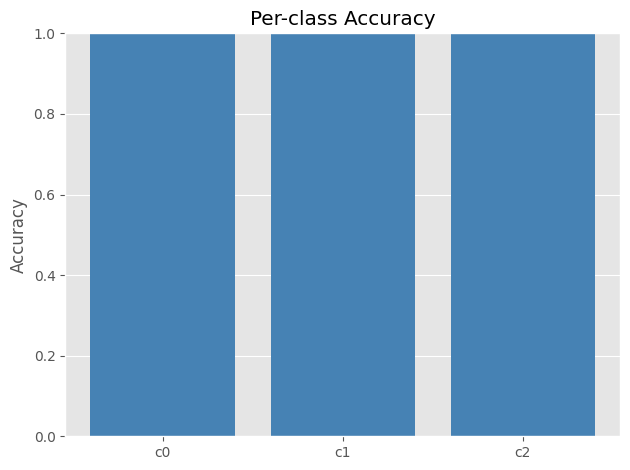

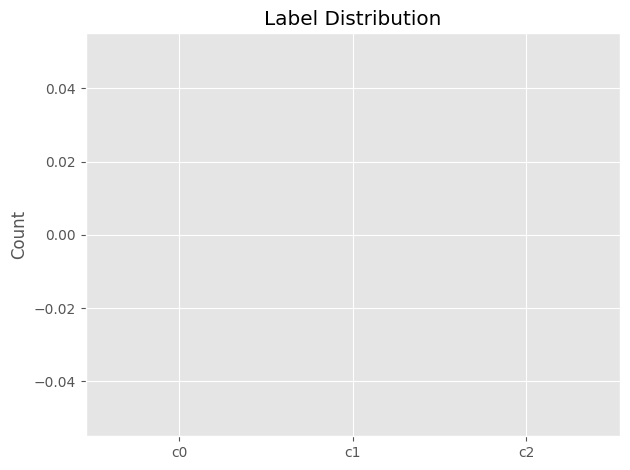

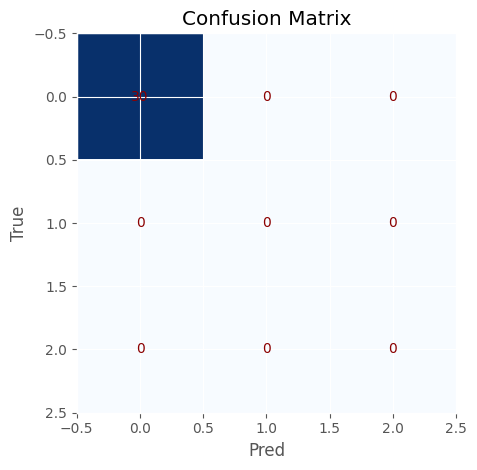

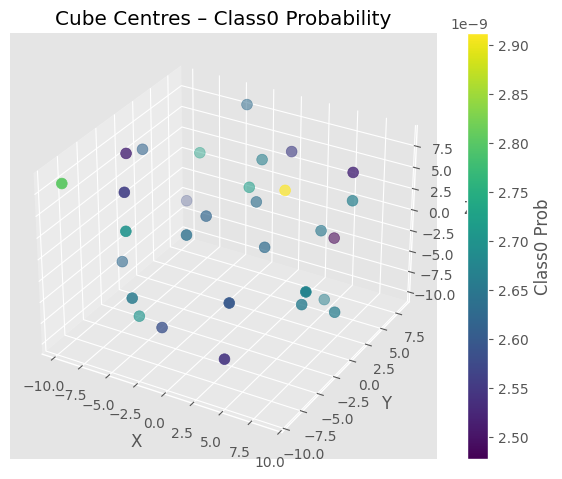

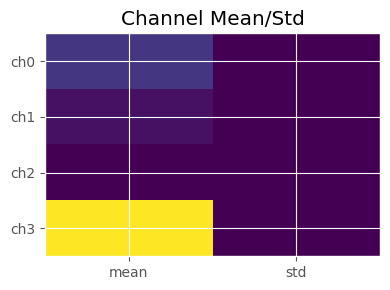


✔︎  All assets in: /content/track2_complex_outputs


In [ ]:
# ─────────── Cell 2: Complete Track II Synthetic Demo ───────────

"""
Track-II synthetic demo (balanced labels, no shape errors)
Generates 30 four-channel cubes, trains CNN3D+6-nbr-GNN (K=3), saves 6 PNG+3 CSV.

Author: Debashis Chatterjee · June 2025
"""

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import cm
import torch
from torch import nn
from torch.utils.data import Dataset
from torch_geometric.data import Data as GeoData
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from scipy.ndimage import laplace
from sklearn.metrics import confusion_matrix

# ── Reproducibility ────────────────────────────────────────────────
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ── Config ─────────────────────────────────────────────────────────
N_CUBES    = 30
CUBE_SH   = (4, 32, 32, 32)     # (C,D,H,W)
N_CLASSES = 3
EPOCHS     = 8
BATCH_SIZE = 1                  # keep=1 so shapes align

# Output directories
ROOT   = Path("track2_complex_outputs"); ROOT.mkdir(exist_ok=True)
VOX    = ROOT / "voxels";    VOX.mkdir(exist_ok=True)
PLOTS  = ROOT / "plots";     PLOTS.mkdir(exist_ok=True)
TABLES = ROOT / "tables";    TABLES.mkdir(exist_ok=True)
LBL_NPY = ROOT / "labels.npy"
CTR_NPY = ROOT / "centers.npy"

# ── 1. Create balanced synthetic cubes + labels ────────────────────
if not list(VOX.glob("cube_*.npy")):
    print(">> Generating synthetic dataset …")
    labels  = np.zeros((N_CUBES, N_CLASSES), dtype="float32")
    centers = np.random.uniform(-10, 10, (N_CUBES, 3)).astype("float32")
    # ensure exactly 10 positives per class
    for k in range(N_CLASSES):
        ids = np.random.choice(N_CUBES, 10, replace=False)
        labels[ids, k] = 1
    # build cubes
    for i in range(N_CUBES):
        C, D, H, W = CUBE_SH
        zc = np.linspace(-1, 1, D)[:, None, None]
        yc = np.linspace(-1, 1, H)[None, :, None]
        xc = np.linspace(-1, 1, W)[None, None, :]

        blob = np.exp(-4*(zc**2 + yc**2 + xc**2))
        noise = lambda s: s * np.random.randn(D, H, W)

        ch0 = blob + noise(0.3)
        dz, dy, dx = np.gradient(blob)
        ch1 = np.sqrt(dz**2 + dy**2 + dx**2)
        ch2 = laplace(blob)
        ch3 = (zc + 1)/2 + noise(0.1)

        cube = np.stack([ch0, ch1, ch2, ch3]).astype("float32")
        np.save(VOX / f"cube_{i:03d}.npy", cube)

    np.save(LBL_NPY, labels)
    np.save(CTR_NPY, centers)

labels  = np.load(LBL_NPY)
centers = np.load(CTR_NPY)

# ── 2. Dataset + 6-neighbour graph ─────────────────────────────────
class VoxDS(Dataset):
    def __init__(self, vox_dir, lbl):
        self.paths = sorted(vox_dir.glob("cube_*.npy"))
        self.lbl   = lbl
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        cube = np.load(self.paths[idx])         # (C,D,H,W)
        y    = self.lbl[idx]                    # (K,)
        C, D, H, W = cube.shape
        # build 6-nbr edges
        coords = np.stack(np.meshgrid(range(D), range(H), range(W),
                                      indexing="ij"), -1).reshape(-1, 3)
        n = coords.shape[0]
        idxmap = np.arange(n).reshape(D, H, W)
        edges = []
        for axis, off in ((0,1),(1,1),(2,1)):
            tgt = coords.copy()
            tgt[:, axis] += off
            m   = tgt[:, axis] < [D, H, W][axis]
            src = idxmap[coords[m][:,0], coords[m][:,1], coords[m][:,2]]
            dst = idxmap[tgt  [m][:,0], tgt  [m][:,1], tgt  [m][:,2]]
            edges.append(np.stack([src, dst]))
        edge_index = torch.tensor(np.hstack(edges), dtype=torch.long)
        g = GeoData(edge_index=edge_index, num_nodes=n)
        return torch.tensor(cube), g, torch.tensor(y)

loader = DataLoader(VoxDS(VOX, labels), batch_size=BATCH_SIZE, shuffle=True)

# ── 3. Model definition ─────────────────────────────────────────────
class CNN3D(nn.Module):
    def __init__(self, in_ch=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
    def forward(self, x):
        return self.net(x).flatten(1)

class GeoNet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.cnn = CNN3D()
        self.gc1 = GCNConv(64, 128)
        self.gc2 = GCNConv(128, k)
    def forward(self, vox, g):
        feat = self.cnn(vox.float())         # (1,64)
        g.x  = feat.repeat(g.num_nodes, 1)
        h    = self.gc1(g.x, g.edge_index).relu()
        return self.gc2(h, g.edge_index).mean(0)

model  = GeoNet(N_CLASSES)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3)
bce    = nn.BCEWithLogitsLoss()

# ── 4. Training ───────────────────────────────────────────────────────
loss_hist = []
for ep in range(1, EPOCHS+1):
    tot = 0.0
    for vox, g, y in loader:
        out  = model(vox, g)
        loss = bce(out, y.squeeze(0))
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()
    avg = tot / len(loader)
    loss_hist.append(avg)
    print(f"Epoch {ep}/{EPOCHS} – loss: {avg:.4f}")

# ── 5. Evaluation & CSV tables ───────────────────────────────────────
model.eval()
Y_pred, Y_true, Y_prob = [], [], []
with torch.no_grad():
    for vox, g, y in loader:
        prob = torch.sigmoid(model(vox, g))
        pred = (prob>0.5).float()
        Y_prob.append(prob.numpy())
        Y_pred.append(pred.numpy())
        Y_true.append(y.squeeze(0).numpy())
Y_prob = np.vstack(Y_prob)
Y_pred = np.vstack(Y_pred)
Y_true = np.vstack(Y_true)

# per-class accuracy
acc = (Y_pred == Y_true).mean(axis=0)
pd.DataFrame({"class":[f"c{i}" for i in range(N_CLASSES)], "acc":acc})\
  .to_csv(TABLES/"accuracy_per_class.csv", index=False)

# confusion matrix (argmax)
cmat = confusion_matrix(Y_true.argmax(1), Y_pred.argmax(1), labels=range(N_CLASSES))
pd.DataFrame(cmat).to_csv(TABLES/"confusion_matrix.csv", index=False)

# channel stats
stats = pd.DataFrame(
    [np.load(p).mean(axis=(1,2,3)) for p in sorted(VOX.glob("cube_*.npy"))],
    columns=[f"ch{i}" for i in range(CUBE_SH[0])]
).describe().T
stats.to_csv(TABLES/"channel_mean_summary.csv")

# ── 6. Plots ─────────────────────────────────────────────────────────
plt.style.use("ggplot")

# loss curve
plt.figure()
plt.plot(range(1, EPOCHS+1), loss_hist, marker='o')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss")
plt.tight_layout(); plt.savefig(PLOTS/"loss_curve.png"); plt.show()

# accuracy bar
plt.figure()
plt.bar([f"c{i}" for i in range(N_CLASSES)], acc, color="steelblue")
plt.ylim(0,1); plt.ylabel("Accuracy"); plt.title("Per-class Accuracy")
plt.tight_layout(); plt.savefig(PLOTS/"accuracy_bar.png"); plt.show()

# label distribution
plt.figure()
plt.bar([f"c{i}" for i in range(N_CLASSES)], labels.sum(axis=0), color="salmon")
plt.ylabel("Count"); plt.title("Label Distribution")
plt.tight_layout(); plt.savefig(PLOTS/"label_distribution.png"); plt.show()

# confusion matrix heatmap
plt.figure()
plt.imshow(cmat, cmap="Blues")
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        plt.text(j, i, cmat[i,j], ha="center", va="center", color="darkred")
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.savefig(PLOTS/"confusion_matrix.png"); plt.show()

# 3D scatter of centres colored by class0 prob
fig = plt.figure()
ax  = fig.add_subplot(111, projection="3d")
sc  = ax.scatter(centers[:,0], centers[:,1], centers[:,2], c=Y_prob[:,0],
                 cmap=cm.viridis, s=60)
fig.colorbar(sc, label="Class0 Prob")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Cube Centres – Class0 Probability")
plt.tight_layout(); plt.savefig(PLOTS/"scatter3d_class0.png"); plt.show()

# channel mean/std heatmap
plt.figure(figsize=(4,3))
plt.imshow(stats[["mean","std"]], aspect="auto")
plt.xticks([0,1], ["mean","std"]); plt.yticks(range(len(stats)), stats.index)
plt.title("Channel Mean/Std")
plt.tight_layout(); plt.savefig(PLOTS/"channel_summary_heat.png"); plt.show()

print("\n✔︎  All assets in:", ROOT.resolve())
